In [80]:
# F1 ML Model - Neha G

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np 

In [81]:
# Section 1 - configuration
DATASET_PATH = 'f1_pitstops_2018_2024.csv'  
TARGET_VARIABLE = 'Lap Time Variation'   

TOP_TIER_CONSTRUCTORS = ['Mercedes', 'Ferrari', 'Red Bull']
OTHER_TIER_CONSTRUCTORS = [
    'Sauber', 'Toro Rosso', 'Haas F1 Team', 'Williams', 'Force India', 
    'Renault', 'AlphaTauri', 'Aston Martin', 'McLaren', 'Alpine', 
    'Racing Point', 'Visa Cash App RB F1 Team', 'Stake F1 Team Kick Sauber'
]

print("Loading F1 dataset...")

Loading F1 dataset...


In [82]:
# Section 2 - data loading and cleaning
try:
    raw_dataframe = pd.read_csv(DATASET_PATH)
    print(f"\nLoaded dataset: {len(raw_dataframe)} rows")
except FileNotFoundError:
    print(f"Can't find {DATASET_PATH}")
    exit()

# Drop rows with missing target values
original_dataset_size = len(raw_dataframe)
clean_dataframe = raw_dataframe.dropna(subset=[TARGET_VARIABLE])
dropped_rows = original_dataset_size - len(clean_dataframe)
if dropped_rows > 0:
    print(f"Dropped {dropped_rows} rows with missing target values ('{TARGET_VARIABLE}')")

# Select only the useful columns 
input_features = ['Stint Length', 'Air_Temp_C', 'Tire Compound', 'Constructor']
preprocessed_dataframe = clean_dataframe[input_features + [TARGET_VARIABLE]].copy()

# Feature engineering - create a simplified team tier feature
def categorise_team_tier(constructor_name):
    return 'Top_Tier' if constructor_name in TOP_TIER_CONSTRUCTORS else 'Other_Tier'
    
preprocessed_dataframe['Team_Category'] = preprocessed_dataframe['Constructor'].apply(categorise_team_tier)
preprocessed_dataframe = preprocessed_dataframe.drop('Constructor', axis=1)

# One-hot encoding
encoded_dataframe = pd.get_dummies(preprocessed_dataframe, 
                                    columns=['Tire Compound', 'Team_Category'], 
                                    drop_first=False)

# Prepare feature matrix and target
model_features = [col for col in encoded_dataframe.columns 
                  if col not in [TARGET_VARIABLE, 'Team_Category_Other_Tier']]
feature_matrix = encoded_dataframe[model_features]
target_variable = encoded_dataframe[TARGET_VARIABLE]

# Feature list output
print(f"\nUsing {len(model_features)} features for the model:")
for feature in model_features:
    print(f"  - {feature}")

# Split data into training and testing sets
X_training, X_testing, Y_training, Y_testing = train_test_split(
    feature_matrix, target_variable, test_size=0.3, random_state=42
)

# Split output
print(f"\nDataset split:")
print(f"  - Training set: {len(X_training)} rows")
print(f"  - Test set:     {len(X_testing)} rows")


Loaded dataset: 7374 rows
Dropped 185 rows with missing target values ('Lap Time Variation')

Using 11 features for the model:
  - Stint Length
  - Air_Temp_C
  - Tire Compound_HARD
  - Tire Compound_HYPERSOFT
  - Tire Compound_INTERMEDIATE
  - Tire Compound_MEDIUM
  - Tire Compound_SOFT
  - Tire Compound_SUPERSOFT
  - Tire Compound_ULTRASOFT
  - Tire Compound_WET
  - Team_Category_Top_Tier

Dataset split:
  - Training set: 5032 rows
  - Test set:     2157 rows


In [83]:
# Section 3: unified model bias analysis
unified_regression_model = DecisionTreeRegressor(random_state=42)
unified_regression_model.fit(X_training, Y_training)

# Make predictions 
unified_predictions = unified_regression_model.predict(X_testing)

# Build results table for fairness analysis
performance_results = X_testing.copy()
performance_results['actual_values'] = Y_testing
performance_results['predicted_values'] = unified_predictions

performance_results['team_performance_tier'] = np.where(
    performance_results['Team_Category_Top_Tier'] == 1,
    'Top_Tier',
    'Other_Tier'
)

# Calculate MAE for each team tier
top_tier_performance_error = mean_absolute_error(
    performance_results[performance_results['team_performance_tier'] == 'Top_Tier']['actual_values'],
    performance_results[performance_results['team_performance_tier'] == 'Top_Tier']['predicted_values']
)

other_tier_performance_error = mean_absolute_error(
    performance_results[performance_results['team_performance_tier'] == 'Other_Tier']['actual_values'],
    performance_results[performance_results['team_performance_tier'] == 'Other_Tier']['predicted_values']
)

# Calculate the initial bias
initial_performance_bias = abs(top_tier_performance_error - other_tier_performance_error)

# Print results 
print("\n" + "-"*60)
print("UNIFIED MODEL FAIRNESS CHECK")
print("-"*60)

print(f"Top-tier teams MAE:   {top_tier_performance_error:.4f}")
print(f"Other-tier teams MAE: {other_tier_performance_error:.4f}")
print(f"Bias (difference):    {initial_performance_bias:.4f}")


------------------------------------------------------------
UNIFIED MODEL FAIRNESS CHECK
------------------------------------------------------------
Top-tier teams MAE:   0.0071
Other-tier teams MAE: 0.0097
Bias (difference):    0.0025


In [ ]:
# Section 4: bias mitigation
train_data_for_specialisation = X_training.copy()
train_data_for_specialisation['target'] = Y_training

# Split training data by team tier
top_tier_training_data = train_data_for_specialisation[train_data_for_specialisation['Team_Category_Top_Tier'] == 1]
other_tier_training_data = train_data_for_specialisation[train_data_for_specialisation['Team_Category_Top_Tier'] == 0]

# Select features for specialized models
specialised_model_features = [
    col for col in train_data_for_specialisation.columns
    if col not in ['target', 'Team_Category_Top_Tier', 'Team_Category_Other_Tier']
]

# Train Top-Tier specialised model
top_tier_feature_matrix = top_tier_training_data[specialised_model_features]
top_tier_target = top_tier_training_data['target']

top_tier_specialised_model = DecisionTreeRegressor(random_state=42)
top_tier_specialised_model.fit(top_tier_feature_matrix, top_tier_target)

# Train Other-Tier specialised model
other_tier_feature_matrix = other_tier_training_data[specialised_model_features]
other_tier_target = other_tier_training_data['target']

other_tier_specialised_model = DecisionTreeRegressor(random_state=42)
other_tier_specialised_model.fit(other_tier_feature_matrix, other_tier_target)



DecisionTreeRegressor(random_state=42)

In [85]:
# Section 5: specialized model evaluation
test_features_for_specialised_models = performance_results[specialised_model_features]

# Make specialized predictions
specialised_predictions = []
for idx, row in performance_results.iterrows():
    if row['team_performance_tier'] == 'Top_Tier':
        pred = top_tier_specialised_model.predict(test_features_for_specialised_models.loc[idx:idx])[0]
    else:
        pred = other_tier_specialised_model.predict(test_features_for_specialised_models.loc[idx:idx])[0]
    specialised_predictions.append(pred)

performance_results['specialised_predictions'] = specialised_predictions

# Calculate MAE for specialized models
specialised_top_tier_error = mean_absolute_error(
    performance_results[performance_results['team_performance_tier'] == 'Top_Tier']['actual_values'],
    performance_results[performance_results['team_performance_tier'] == 'Top_Tier']['specialised_predictions']
)

specialised_other_tier_error = mean_absolute_error(
    performance_results[performance_results['team_performance_tier'] == 'Other_Tier']['actual_values'],
    performance_results[performance_results['team_performance_tier'] == 'Other_Tier']['specialised_predictions']
)

# Calculate reduced bias
reduced_performance_bias = abs(specialised_top_tier_error - specialised_other_tier_error)

# Print results
print("\n" + "-"*60)
print("SPECIALISED MODEL FAIRNESS CHECK")
print("-"*60)

print(f"Top-tier MAE (specialized):     {specialised_top_tier_error:.4f}")
print(f"Other-tier MAE (specialized):   {specialised_other_tier_error:.4f}")
print(f"Remaining bias after mitigation: {reduced_performance_bias:.4f}")



------------------------------------------------------------
SPECIALISED MODEL FAIRNESS CHECK
------------------------------------------------------------
Top-tier MAE (specialized):     0.0115
Other-tier MAE (specialized):   0.0111
Remaining bias after mitigation: 0.0004



--------------------------------------------------------------------------------
FINAL RESULTS
--------------------------------------------------------------------------------
       Team Group  Unified Model  Specialised Models
   Top-Tier Teams         0.0071              0.0115
      Other Teams         0.0097              0.0111
Bias (difference)         0.0025              0.0004

Bias reduction: 83.8%
Success! Specialised models reduced bias


<Figure size 1000x600 with 0 Axes>

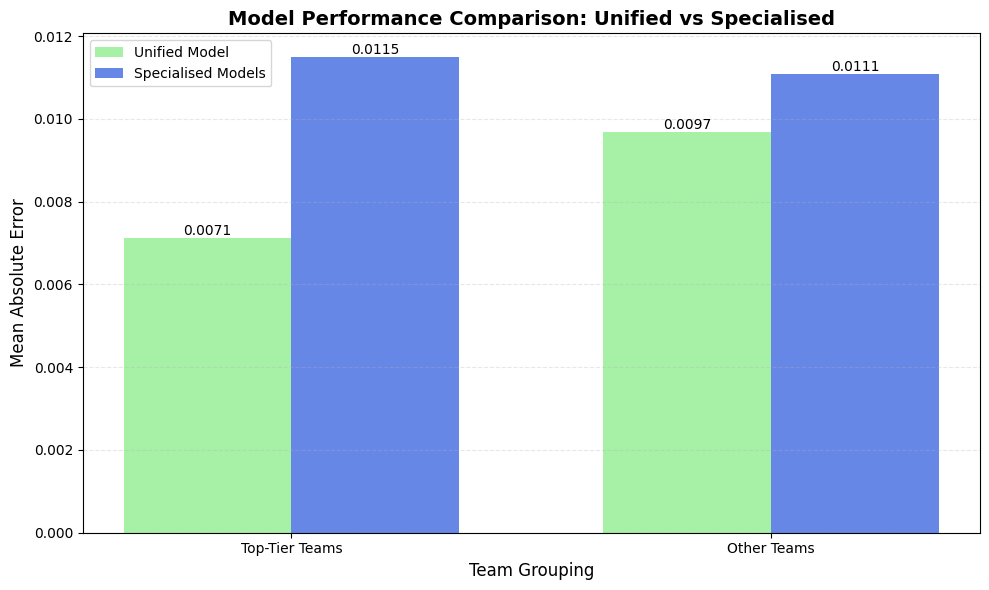

In [86]:
# Section 6: final report and visualisation
print("\n" + "-"*80)
print("FINAL RESULTS")
print("-"*80)

comparison_dataframe = pd.DataFrame({
    'Team Group': ['Top-Tier Teams', 'Other Teams', 'Bias (difference)'],
    'Unified Model': [top_tier_performance_error, other_tier_performance_error, initial_performance_bias],
    'Specialised Models': [specialised_top_tier_error, specialised_other_tier_error, reduced_performance_bias],
})

print(comparison_dataframe.to_string(index=False, float_format='%.4f'))

bias_reduction_percentage = ((initial_performance_bias - reduced_performance_bias) / initial_performance_bias) * 100 if initial_performance_bias > 0 else 0
print(f"\nBias reduction: {bias_reduction_percentage:.1f}%")

if reduced_performance_bias < initial_performance_bias:
    print("Success! Specialised models reduced bias")
else:
    print("Hmm, specialised models didn't help much...")

# Visualisation
performance_groups = ['Top-Tier Teams', 'Other Teams']
unified_model_errors = [top_tier_performance_error, other_tier_performance_error]
specialised_model_errors = [specialised_top_tier_error, specialised_other_tier_error]

plt.figure(figsize=(10, 6))
x_positions = np.arange(len(performance_groups))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
unified_bars = ax.bar(x_positions - bar_width/2, unified_model_errors, bar_width, 
                      label='Unified Model', color='lightgreen', alpha=0.8)
specialised_bars = ax.bar(x_positions + bar_width/2, specialised_model_errors, bar_width, 
                          label='Specialised Models', color='royalblue', alpha=0.8)

# Plot customization
ax.set_xlabel('Team Grouping', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Model Performance Comparison: Unified vs Specialised', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels(performance_groups, fontsize=10)

# Add value labels on bars
for bar1, bar2 in zip(unified_bars, specialised_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1, f'{height1:.4f}', 
            ha='center', va='bottom', fontsize=10)
    ax.text(bar2.get_x() + bar2.get_width()/2., height2, f'{height2:.4f}', 
            ha='center', va='bottom', fontsize=10)

ax.legend(loc='best')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()